In [1]:
# define logging and working directory
from ProjectRoot import change_wd_to_project_root 
change_wd_to_project_root()
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from src.utils.notebook_imports import *
Console_and_file_logger('Clean_Repo')

search for root_dir and set working directory
Working directory set to: /mnt/data/git/cardio


Using TensorFlow backend.
2019-10-29 11:15:24,989 INFO -------------------- Start --------------------
2019-10-29 11:15:24,990 INFO Working directory: /mnt/data/git/cardio.
2019-10-29 11:15:24,990 INFO Log file: ./logs/Clean_Repo.log


# interactive plots

In [1]:
# Standard plotly imports
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode# Using plotly + cufflinks in offline mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

In [20]:
@interact_manual
def show_articles_more_than(column=df.columns, 
                            x=(0, 100, 1)):
    return df.loc[df[column] > x]

interactive(children=(Dropdown(description='column', options=('Unnamed: 0', 'Unnamed: 0.1', 'background', 'rv'…

In [26]:
!pip uninstall --yes plotly cufflinks

#!conda uninstall --yes plotly cufflinks
#!pip install plotly==4.2 cufflinks

Uninstalling plotly-3.10.0:
  Successfully uninstalled plotly-3.10.0
Uninstalling cufflinks-0.17.0:
  Successfully uninstalled cufflinks-0.17.0


In [11]:
list(df.select_dtypes(include=['int64', 'float64']).columns)

['Unnamed: 0',
 'Unnamed: 0.1',
 'background',
 'rv',
 'myo',
 'lv',
 't',
 't_norm',
 '.50-quantle',
 '.75-quantile',
 '.99-quantile',
 'LargestImagePixelValue',
 'MagneticFieldStrength',
 'PatientBirthDate',
 'SliceThickness',
 'SmallestImagePixelValue',
 'column',
 'dimension',
 'max',
 'mean',
 'min',
 'row',
 'slices',
 't-axis',
 't-spacing',
 'x-axis',
 'x-spacing',
 'y-axis',
 'y-spacing',
 'z-axis',
 'z-spacing',
 '? vt',
 'Age at corrective surgery (years) Alter_correctOP',
 'Age at enrollment (years) age',
 'Age at palliation (years) alter_palliation',
 'Antiarrhythmic medication in %   yes or no antiarrhyth_c',
 'Aortic insufficiency grades 0-4 aortinsuf',
 'BMI BMI',
 'Birth weight in grams gebgewicht',
 'Blood pressure diastolic in mmHg rrdias',
 'Blood pressure mean in mmHg rrmiddle',
 'Blood pressure systolic in mmHg rrsys',
 'ECG Rhythm rhythmus.1',
 'Echocardiography Mean Gradient PA in mmHg pkmean',
 'Exercise testing Peak oxygen uptake in ml/kg/min at anaerobic thre

In [14]:
import cufflinks as cf

@interact
def scatter_plot(x=list(df.select_dtypes(include=['int64', 'float64']).columns), 
                 y=list(df.select_dtypes(include=['int64', 'float64']).columns)[1:],
                 theme=list(cf.themes.THEMES.keys()), 
                 colorscale=list(cf.colors._scales_names.keys())):
    

        #         xTitle=x.title(), yTitle=y.title(), 
    #         text='title',
    #         title=f'{y.title()} vs {x.title()}'
    
    df.iplot(kind='scatter', x=x, y=y, mode='markers', theme=theme, colorscale=colorscale)

interactive(children=(Dropdown(description='x', options=('Unnamed: 0', 'Unnamed: 0.1', 'background', 'rv', 'my…

# 3D Quiver plot

In [2]:
from src.utils.utils_io import init_config
df = pd.read_csv('reports/vae/3d_gcn_flowfield.csv')
# create a config
EXPERIMENT = 'motion/3d/gcn'
now = datetime.datetime.now()
# image params
DIM = [16, 224, 224]
SPACING = [6, 1.0,1.0] # used by sitk, opposite order than numpy or tensorflow!
# Greyscale images
IMG_CHANNELS = 3    # <------------------ change this to 1 for CMR images
# RV = 1 = Y[...,0] 
# Myo = 2 = Y[...,1] 
# LV = 3 = Y[...,2]
MASK_VALUES = [0, 1, 2, 3]  
MASK_CLASSES = len(MASK_VALUES)
ARCHITECTURE = '3D'
AUGMENT = False
SHUFFLE = True
AUGMENT_GRID = False
SEED = 42
BATCHSIZE =  10 # 64, 16, 1
SCALER = 'MinMax'
EPOCHS = 150
config = init_config(globals(), save=False)

In [3]:
from src.data.generators import VAEFlowfieldGenerator
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
gcn_generator = VAEFlowfieldGenerator(x=df['flowfield_3d'], y=df['flowfield_3d'], config=config)
batch = None
for gcn_batch, _ in zip(gcn_generator,[0,1]):
    x, _ = gcn_batch
    
x.shape

2019-10-29 11:15:32,632 INFO Create DataGenerator
2019-10-29 11:15:32,635 INFO Datagenerator created with: 
 shape: [16, 224, 224]
 batchsize: 10
 Scaler: MinMax
 Images: 808 
 Augment_grid: False 
 Thread workers: 10
2019-10-29 11:15:32,635 INFO No augmentation


(10, 16, 224, 224, 3)

In [6]:
# 3D
def create_quiver_plot_3d(flowfield_3d=None, ax=None):
    """
    Function to create an easy flowfield from the voxelmorph output
    Needs a 2D flowfield, function can handle 2D or 3D vectors as channels
    :param flowfield_2d: numpy array with shape x, y, vectors
    :param ax: matplotlib ax object which should be used for plotting,
    create a new ax object if none is given
    :return: ax to plot or save
    """

    N = 14  # take only every n vector
    Nz = 2
    nx = 224  # define ticks in x
    ny = 224  # define ticks in y
    nz = 16
    
    flowfield_3d = np.repeat(flowfield_3d, 2, axis=0)
    
    if not ax:
        fig = plt.figure(figsize=(15,15))
        ax = Axes3D(fig)


    # extract flowfield for x and y
    if flowfield_3d.shape[-1] == 3:  # originally a 3d flowfield
        Z_ = flowfield_3d[..., 0]
        X_ = flowfield_3d[..., 1]
        Y_ = flowfield_3d[..., 2]
        
    elif flowfield_3d.shape[-1] == 2:  # 2d flowfield
        X_ = flowfield_3d[..., 0]
        Y_ = flowfield_3d[..., 1]
        
    print('X_ shape {}'.format(X_.shape))
    print('Y_ shape {}'.format(Y_.shape))
    print('Z_ shape {}'.format(Z_.shape))

    # slice flowfield, take every N value
    Fx = X_[::Nz, ::N, ::N]
    Fy = Y_[::Nz, ::N, ::N]
    Fz = Z_[::Nz, ::N, ::N]
    print('FX_ shape {}'.format(Fx.shape))
    print('FY_ shape {}'.format(Fy.shape))
    print('FZ_ shape {}'.format(Fz.shape))
    nzcols, nrows, ncols = Fx.shape

    # create a grid with the size nx/ny and ncols/nrows
    x_ = np.linspace(0, nx, ncols)
    y_ = np.linspace(0, ny, nrows)
    z_ = np.linspace(0, nz, nzcols)
    zi, xi, yi = np.meshgrid(z_, x_, y_, indexing='xy')

    # plot
    ax.set_title('Flowfield')
    #ax.quiver(xi, yi, zi, Fx, Fy, Fz, alpha=.5, color='b')
    ax.quiver(xi, yi, zi, Fx, Fy, Fz, linewidth=.5, color ='k') 
    return ax

X_ shape (32, 224, 224)
Y_ shape (32, 224, 224)
Z_ shape (32, 224, 224)
FX_ shape (16, 16, 16)
FY_ shape (16, 16, 16)
FZ_ shape (16, 16, 16)


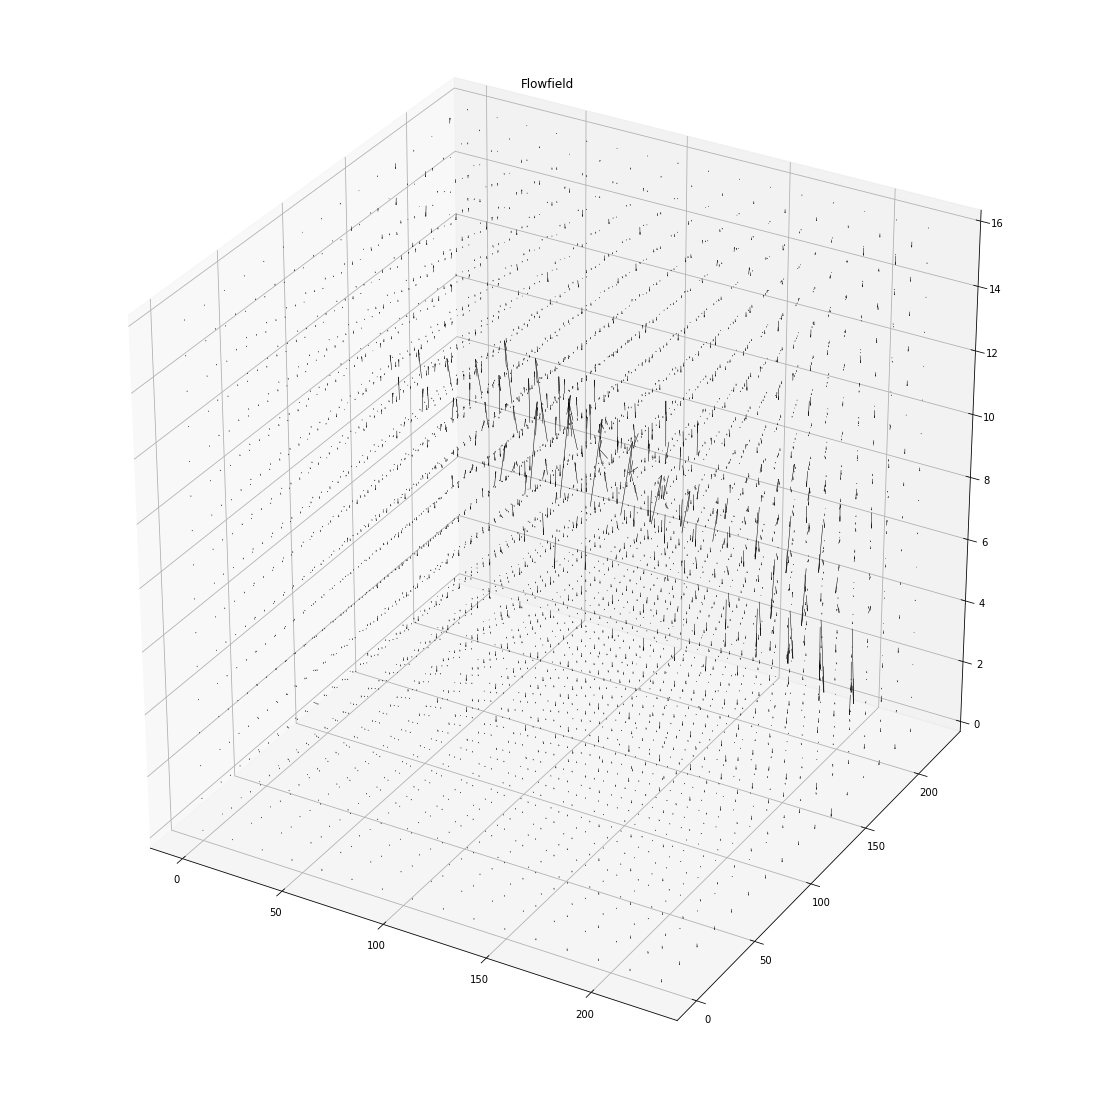

In [10]:
%matplotlib inline
create_quiver_plot_3d(x[3])

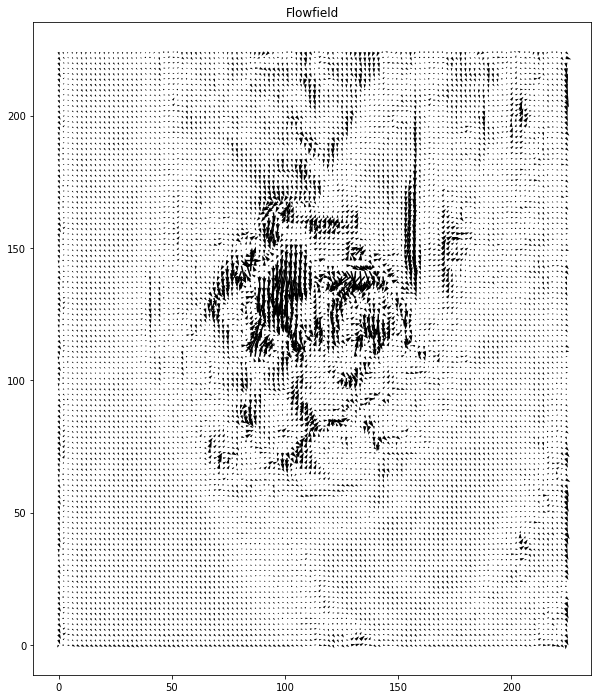

In [13]:
create_2dquiver_plot(x[0,8,...])

In [12]:
def create_2dquiver_plot(flowfield_2d=None, ax=None):
    """
    Function to create an easy flowfield from the voxelmorph output
    Needs a 2D flowfield, function can handle 2D or 3D vectors as channels
    :param flowfield_2d: numpy array with shape x, y, vectors
    :param ax: matplotlib ax object which should be used for plotting,
    create a new ax object if none is given
    :return: ax to plot or save
    """

    N = 2  # take only every n vector
    nx = 224  # define ticks in x
    ny = 224  # define ticks in y
    if not ax:
        fig, ax = plt.subplots(figsize=(10,12))

    # extract flowfield for x and y
    if flowfield_2d.shape[-1] == 3:  # originally a 3d flowfield
        X_ = flowfield_2d[..., 1]
        Y_ = flowfield_2d[..., 2]
    elif flowfield_2d.shape[-1] == 2:  # 2d flowfield
        X_ = flowfield_2d[..., 1]
        Y_ = flowfield_2d[..., 0]

    
    # slice flowfield, take every N value
    Fx = X_[::N, ::N]
    Fy = Y_[::N, ::N]
    nrows, ncols = Fx.shape

    # create a grid with the size nx/ny and ncols/nrows
    x_ = np.linspace(0, nx, ncols)
    y_ = np.linspace(0, ny, nrows)
    xi, yi = np.meshgrid(x_, y_, indexing='xy')

    # plot
    ax.set_title('Flowfield')
    ax.quiver(xi, yi, Fx, Fy, alpha=.5)
    ax.quiver(xi, yi, Fx, Fy, linewidth=.5)
    return ax

# Multi line output

In [12]:
# defined in ~/.ipython/profile_default/ipython_config.py
# or with this import: 
test_list = [1] * 10
len(test_list)
test_list[:4]


10

[1, 1, 1, 1]

# Easy links to documentation

In [14]:
s = "teststring"
s.s

Docstring:
S.strip([chars]) -> str

Return a copy of the string S with leading and trailing
whitespace removed.
If chars is given and not None, remove characters in chars instead.
Type:      builtin_function_or_method


# ipython magic

In [4]:
%lsmagic

Available line magics:
%alias  %alias_magic  %autoawait  %autocall  %automagic  %autosave  %bookmark  %cat  %cd  %clear  %colors  %conda  %config  %connect_info  %cp  %debug  %dhist  %dirs  %doctest_mode  %ed  %edit  %env  %gui  %hist  %history  %killbgscripts  %ldir  %less  %lf  %lk  %ll  %load  %load_ext  %loadpy  %logoff  %logon  %logstart  %logstate  %logstop  %ls  %lsmagic  %lx  %macro  %magic  %man  %matplotlib  %mkdir  %more  %mv  %notebook  %page  %pastebin  %pdb  %pdef  %pdoc  %pfile  %pinfo  %pinfo2  %pip  %popd  %pprint  %precision  %prun  %psearch  %psource  %pushd  %pwd  %pycat  %pylab  %qtconsole  %quickref  %recall  %rehashx  %reload_ext  %rep  %rerun  %reset  %reset_selective  %rm  %rmdir  %run  %save  %sc  %set_env  %store  %sx  %system  %tb  %time  %timeit  %unalias  %unload_ext  %who  %who_ls  %whos  %xdel  %xmode

Available cell magics:
%%!  %%HTML  %%SVG  %%bash  %%capture  %%debug  %%file  %%html  %%javascript  %%js  %%latex  %%markdown  %%perl  %%prun  %%pypy  %%

In [15]:
# this cell should fail
def foo():
    a = []
    a.append(1)
    c=None
    c.append()
foo()

AttributeError: 'NoneType' object has no attribute 'append'

> <ipython-input-15-6395dff9c87c>(6)foo()
      3     a = []
      4     a.append(1)
      5     c=None
----> 6     c.append()
      7 foo()



ipdb>  c


In [16]:
# http://wangchuan.github.io/coding/2017/07/12/ipdb-cheat-sheet.html
%debug

> <ipython-input-15-6395dff9c87c>(6)foo()
      3     a = []
      4     a.append(1)
      5     c=None
----> 6     c.append()
      7 foo()



ipdb>  w


  <ipython-input-15-6395dff9c87c>(7)<module>()
      3     a = []
      4     a.append(1)
      5     c=None
      6     c.append()
----> 7 foo()

> <ipython-input-15-6395dff9c87c>(6)foo()
      3     a = []
      4     a.append(1)
      5     c=None
----> 6     c.append()
      7 foo()



ipdb>  u


> <ipython-input-15-6395dff9c87c>(7)<module>()
      3     a = []
      4     a.append(1)
      5     c=None
      6     c.append()
----> 7 foo()



ipdb>  d


> <ipython-input-15-6395dff9c87c>(6)foo()
      3     a = []
      4     a.append(1)
      5     c=None
----> 6     c.append()
      7 foo()



ipdb>  c


# run other notebooks

2019-09-19 09:28:55,051 INFO -------------------- Start --------------------
2019-09-19 09:28:55,052 INFO Working directory: /mnt/data/git/cardio.
2019-09-19 09:28:55,052 INFO Log file: ./logs/Clean_Repo.log


search for root_dir and set working directory
Working directory set to: /mnt/data/git/cardio


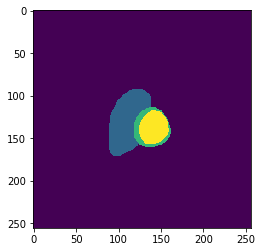

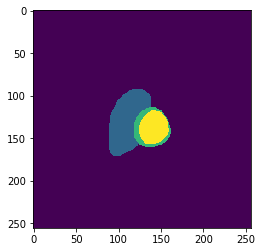

In [18]:
%run notebooks/Jupyter_Demo_tests.ipynb

In [7]:
/str 11

'11'

In [15]:
%config

Available objects for config:
     AliasManager
     DisplayFormatter
     HistoryManager
     IPCompleter
     IPKernelApp
     InlineBackend
     LoggingMagics
     MagicsManager
     OSMagics
     PrefilterManager
     ScriptMagics
     StoreMagics
     ZMQInteractiveShell


# Load external modules or files

In [19]:
# %load src/utils/utils_io.py
import os
import logging
from time import time
import platform
if not platform.system() == 'Windows':
    import matplotlib as mpl
    mpl.use('TkAgg')
import matplotlib.pyplot as plt
import json

# define some helper classes
# Define an individual logger
class Console_and_file_logger():
    def __init__(self, logfile_name='Log', log_lvl = logging.INFO, path='./logs/'):
        """
        Create your own logger
        prints all messages into the given logfile and ouput it on console
        :param logfile_name:
        :param log_dir:
        """

        # Define the general formatting schema
        formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')
        logger = logging.getLogger()
        logger.handlers = []
        if not logger.handlers:

            # Create log directory
            #log_dir = os.getcwd() + path
            log_f = os.path.join(path,logfile_name + '.log')
            ensure_dir(os.path.dirname(os.path.abspath(log_f)))

            # Define logfile handler and file
            hdlr = logging.FileHandler(log_f)
            hdlr.setFormatter(formatter)

            # Define console output handler
            hdlr_console = logging.StreamHandler()
            hdlr_console.setFormatter(formatter)

            # Add both handlers to our logger instance
            logger.addHandler(hdlr)
            logger.addHandler(hdlr_console)
            logger.setLevel(log_lvl)

            cwd = os.getcwd()
            logging.info('{} {} {}'.format('--' * 10, 'Start', '--' * 10))
            logging.info('Working directory: {}.'.format(cwd))
            logging.info('Log file: {}'.format(log_f))


def ensure_dir(file_path):
    """
    Make sure a directory exists or create it
    :param file_path:
    :return:
    """
    if not os.path.exists(file_path):
        logging.debug('Creating directory {}'.format(file_path))
        os.makedirs(file_path)

def save_plot(fig, path, filename='', override=False, tight=True):
    """
    Saves an matplotlib figure to the given path + filename
    If the figure exists, ad a number at the end and increase it
    as long as there is already an image with this name
    :param fig:
    :param path:
    :param filename:
    :return:
    """
    logging.debug('Trying to save to {0}'.format(path))
    ensure_dir(path)
    if tight:
        plt.tight_layout()

    i = 0
    if override:
        newname = '{}.png'.format(filename)
        fig.savefig(os.path.join(path , newname))
    else:
        while True:
            i += 1
            newname = '{}{:d}.png'.format(filename + '_', i)
            if os.path.exists(os.path.join(path , newname)):
                continue
            fig.savefig(os.path.join(path , newname))
            break
    logging.debug('Image saved: {}'.format(os.path.join(path , newname)))
    # free memory, close fig
    plt.close(fig)
    
    
def get_metadata_maybe(sitk_img, key, default='not_found'):
    # helper for unicode decode errors
    try:
        value = sitk_img.GetMetaData(key)
    except Exception as e:
        logging.debug('key not found: {}, {}'.format(key, e))
        value = default
    # need to encode/decode all values because of unicode errors in the dataset
    if not isinstance(value, int):
        value = value.encode('utf8','backslashreplace').decode('utf-8').replace('\\udcfc','ue')
    return value
    

def init_config(config, save=True):

    """
    Extract all config params (CAPITAL letters) from global or local namespace
    save a serializable version to disk
    make sure all config paths exist

    :param config:
    :param save:
    :return: config (dict) with all training/evaluation params
    """

    # make sure config path and experiment name are set
    exp = config.get('EXPERIMENT', 'UNDEFINED')
    config['CONFIG_PATH'] = config.get('CONFIG_PATH', os.path.join('reports/config/', exp))
    config['TENSORBOARD_LOG_DIR'] = config.get('TENSORBOARD_LOG_DIR', os.path.join('reports/tensorboard_logs/', exp))
    config['MODEL_PATH'] = config.get('MODEL_PATH', os.path.join('models/', exp))
    config['HISTORY_PATH'] = config.get('HISTORY_PATH', os.path.join('reports/history/', exp))

    # make sure all paths exists
    ensure_dir(config['TENSORBOARD_LOG_DIR'])
    ensure_dir(config['MODEL_PATH'])
    ensure_dir(config['CONFIG_PATH'])
    ensure_dir(config['HISTORY_PATH'])


    # Define a config for param injection and save it for usage during evaluation, save all upper key,value pairs from global namespace
    config = dict(((key, value) for key, value in config.items()
                   if key.isupper() and key not in ['HTML', 'K']))

    
    if save:
        # convert functions to string representations
        write_config = dict([(key, value.__name__) if callable(value) else (key, value) for key, value in config.items()])

        # save only simple data types
        write_config = dict(((key, value) for key, value in write_config.items()
                         if type(value) in [bool, int, str, float, list, dict]))

        # save to disk
        with open(os.path.join(write_config['CONFIG_PATH'],'config.json'), 'w') as fp:
            json.dump(write_config, fp)
    
        logging.info('config saved:\n {}'.format(json.dumps(write_config, indent=4, sort_keys=True)))
    return config

In [21]:
# %load src/utils/utils_io.py
import os
import logging
from time import time
import platform
if not platform.system() == 'Windows':
    import matplotlib as mpl
    mpl.use('TkAgg')
import matplotlib.pyplot as plt
import json

# define some helper classes
# Define an individual logger
class Console_and_file_logger():
    def __init__(self, logfile_name='Log', log_lvl = logging.INFO, path='./logs/'):
        """
        Create your own logger
        prints all messages into the given logfile and ouput it on console
        :param logfile_name:
        :param log_dir:
        """

        # Define the general formatting schema
        formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')
        logger = logging.getLogger()
        logger.handlers = []
        if not logger.handlers:

            # Create log directory
            #log_dir = os.getcwd() + path
            log_f = os.path.join(path,logfile_name + '.log')
            ensure_dir(os.path.dirname(os.path.abspath(log_f)))

            # Define logfile handler and file
            hdlr = logging.FileHandler(log_f)
            hdlr.setFormatter(formatter)

            # Define console output handler
            hdlr_console = logging.StreamHandler()
            hdlr_console.setFormatter(formatter)

            # Add both handlers to our logger instance
            logger.addHandler(hdlr)
            logger.addHandler(hdlr_console)
            logger.setLevel(log_lvl)

            cwd = os.getcwd()
            logging.info('{} {} {}'.format('--' * 10, 'Start', '--' * 10))
            logging.info('Working directory: {}.'.format(cwd))
            logging.info('Log file: {}'.format(log_f))


def ensure_dir(file_path):
    """
    Make sure a directory exists or create it
    :param file_path:
    :return:
    """
    if not os.path.exists(file_path):
        logging.debug('Creating directory {}'.format(file_path))
        os.makedirs(file_path)

def save_plot(fig, path, filename='', override=False, tight=True):
    """
    Saves an matplotlib figure to the given path + filename
    If the figure exists, ad a number at the end and increase it
    as long as there is already an image with this name
    :param fig:
    :param path:
    :param filename:
    :return:
    """
    logging.debug('Trying to save to {0}'.format(path))
    ensure_dir(path)
    if tight:
        plt.tight_layout()

    i = 0
    if override:
        newname = '{}.png'.format(filename)
        fig.savefig(os.path.join(path , newname))
    else:
        while True:
            i += 1
            newname = '{}{:d}.png'.format(filename + '_', i)
            if os.path.exists(os.path.join(path , newname)):
                continue
            fig.savefig(os.path.join(path , newname))
            break
    logging.debug('Image saved: {}'.format(os.path.join(path , newname)))
    # free memory, close fig
    plt.close(fig)
    
    
def get_metadata_maybe(sitk_img, key, default='not_found'):
    # helper for unicode decode errors
    try:
        value = sitk_img.GetMetaData(key)
    except Exception as e:
        logging.debug('key not found: {}, {}'.format(key, e))
        value = default
    # need to encode/decode all values because of unicode errors in the dataset
    if not isinstance(value, int):
        value = value.encode('utf8','backslashreplace').decode('utf-8').replace('\\udcfc','ue')
    return value
    

def init_config(config, save=True):

    """
    Extract all config params (CAPITAL letters) from global or local namespace
    save a serializable version to disk
    make sure all config paths exist

    :param config:
    :param save:
    :return: config (dict) with all training/evaluation params
    """

    # make sure config path and experiment name are set
    exp = config.get('EXPERIMENT', 'UNDEFINED')
    config['CONFIG_PATH'] = config.get('CONFIG_PATH', os.path.join('reports/config/', exp))
    config['TENSORBOARD_LOG_DIR'] = config.get('TENSORBOARD_LOG_DIR', os.path.join('reports/tensorboard_logs/', exp))
    config['MODEL_PATH'] = config.get('MODEL_PATH', os.path.join('models/', exp))
    config['HISTORY_PATH'] = config.get('HISTORY_PATH', os.path.join('reports/history/', exp))

    # make sure all paths exists
    ensure_dir(config['TENSORBOARD_LOG_DIR'])
    ensure_dir(config['MODEL_PATH'])
    ensure_dir(config['CONFIG_PATH'])
    ensure_dir(config['HISTORY_PATH'])


    # Define a config for param injection and save it for usage during evaluation, save all upper key,value pairs from global namespace
    config = dict(((key, value) for key, value in config.items()
                   if key.isupper() and key not in ['HTML', 'K']))

    
    if save:
        # convert functions to string representations
        write_config = dict([(key, value.__name__) if callable(value) else (key, value) for key, value in config.items()])

        # save only simple data types
        write_config = dict(((key, value) for key, value in write_config.items()
                         if type(value) in [bool, int, str, float, list, dict]))

        # save to disk
        with open(os.path.join(write_config['CONFIG_PATH'],'config.json'), 'w') as fp:
            json.dump(write_config, fp)
    
        logging.info('config saved:\n {}'.format(json.dumps(write_config, indent=4, sort_keys=True)))
    return config

# Just open the file

In [20]:
# %%writefile --> save the current cell as python file
%pycat src/utils/utils_io.py

import os
import logging
from time import time
import platform
if not platform.system() == 'Windows':
    import matplotlib as mpl
    mpl.use('TkAgg')
import matplotlib.pyplot as plt
import json

# define some helper classes
# Define an individual logger
class Console_and_file_logger():
    def __init__(self, logfile_name='Log', log_lvl = logging.INFO, path='./logs/'):
        """
        Create your own logger
        prints all messages into the given logfile and ouput it on console
        :param logfile_name:
        :param log_dir:
        """

        # Define the general formatting schema
        formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')
        logger = logging.getLogger()
        logger.handlers = []
        if not logger.handlers:

            # Create log directory
            #log_dir = os.getcwd() + path
            log_f = os.path.join(path,logfile_name + '.log')
            ensure_dir(os.path.dirname(os.path.abspath(log_f)))

            # D

# meassure time of functions

In [21]:
def append_if_not_exists(arr, x):
    if x not in arr:
        arr.append(x)
def foo():
    arr = list()
    for i in range(10000):
        x = np.random.randint(0, 10000)
        append_if_not_exists(arr, x)


In [22]:
%prun foo()

         86310 function calls (76310 primitive calls) in 0.414 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    10000    0.255    0.000    0.256    0.000 <ipython-input-21-7d906bea3ee9>:1(append_if_not_exists)
  10001/1    0.058    0.000    0.421    0.421 {built-in method builtins.exec}
    10000    0.049    0.000    0.051    0.000 {built-in method builtins.eval}
    10000    0.021    0.000    0.021    0.000 {method 'randint' of 'mtrand.RandomState' objects}
        1    0.014    0.014    0.421    0.421 <ipython-input-21-7d906bea3ee9>:4(foo)
    10000    0.007    0.000    0.129    0.000 _importable.py:42(__getattr__)
    10000    0.006    0.000    0.071    0.000 _importable.py:30(__maybe_import__)
    10000    0.002    0.000    0.002    0.000 _importable.py:21(__maybe_import_complementary_imports__)
    10000    0.001    0.000    0.001    0.000 {built-in method builtins.globals}
     6306    0.001    0.000    0.001    0.

In [24]:
%pdb

def pick_and_take():
    picked = np.random.randint(0, 1000)
    raise NotImplementedError()

pick_and_take()

Automatic pdb calling has been turned ON


NotImplementedError: 

> <ipython-input-24-3d4165bcbdc6>(5)pick_and_take()
      3 def pick_and_take():
      4     picked = np.random.randint(0, 1000)
----> 5     raise NotImplementedError()
      6 
      7 pick_and_take()



ipdb>  c


# better resolution and suppress function description

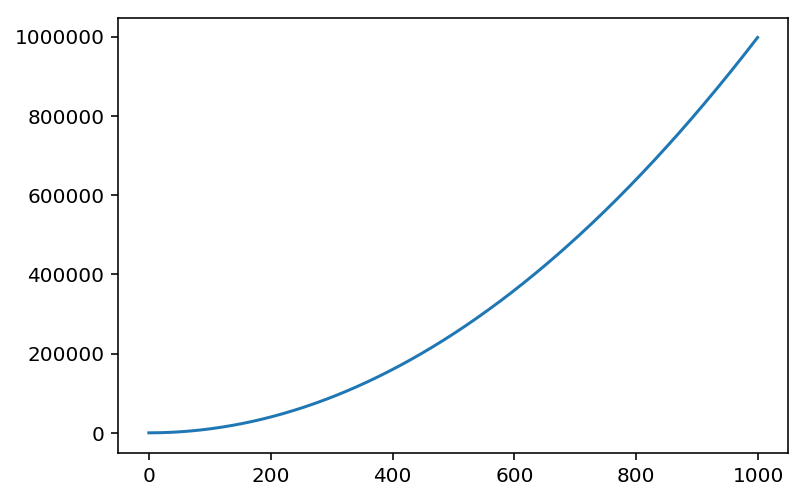

In [26]:
%config InlineBackend.figure_format ='retina'
x = range(1000)
y = [i ** 2 for i in x]
plt.plot(x,y)
plt.show();

# Latex in Markdown cells

$P(A \mid B) = \frac{P(B \mid A)P(A)}{P(B)}$

In [6]:
%%bash
for i in {1..5}
do
   echo "i is $i"
done

i is 1
i is 2
i is 3
i is 4
i is 5


# How to modify multiple lines

In [7]:
# hold down alt, move the cursor
df = pd.DataFrame({
        'Letter': ['a', 'a', 'a', 'b', 'b', 'b', 'c', 'c', 'c', ],
        'X': [4, 3, 5, 2, 1, 7, 7, 5, 9, ],
        'Y': [0, 4, 3, 6, 7, 10, 11, 9, 13, ],
        'Z': [1, 2, 3, 1, 2, 3, 1, 2, , ]
    })

# spell checker extension for markdown cells this is a mistace

# Check docstring of function builtin and own libraries

In [22]:
Console_and_file_logger?
#Console_and_file_logger??

Init signature: Console_and_file_logger(logfile_name='Log', log_lvl=20, path='./logs/')
Docstring:      <no docstring>
Init docstring:
Create your own logger
prints all messages into the given logfile and ouput it on console
:param logfile_name:
:param log_dir:
File:           /mnt/data/git/cardio/src/utils/utils_io.py
Type:           type
Subclasses:     


In [25]:
np.random.choice(np.random.random_sample(10))


0.7944677361135094

# Map function instead of for loops
Slightely faster for predefined functions

In [2]:
def read_cfg_file(f):
    """Helper to open cfg files"""
    with open(f, 'r') as yml_file:
        cfg = yaml.load(yml_file)
    return cfg

def get_pathology_group(folder):
    """Helper to get the patient pathology from the cfg file"""
    cfg_f = os.path.join(folder, 'Info.cfg')
    cfg = read_cfg_file(cfg_f)
    return cfg.get('Group', 'NOGROUP')

In [3]:
def process_patient(p):
    # get patient name
    patient = os.path.basename(os.path.abspath(p))
    abs_path = os.path.abspath(p)

    # get all files for this patient
    files = sorted(glob.glob(os.path.join(abs_path, '*')))

    # get pathology from info.cfg file
    pathology = get_pathology_group(abs_path)

    # build dataframe with files, pathology, and patient-id
    df = pd.DataFrame()
    df['pathologie'] = [pathology] * len(files)
    df['patient'] = [patient] * len(files)
    df['files'] = files
    return df

In [6]:
import glob
folders = glob.glob('data/raw/ACDC/original/all/**/')

In [5]:
%%timeit
dfs = list(map(process_patient, folders))

In [10]:
%%timeit
dfs = [process_patient(folder) for folder in folders]

260 ms ± 51.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
# concat lists
len(folders)

100

In [8]:
folders +=folders

In [9]:
len(folders)

200

In [2]:
# ACDC DATA
kfold_data_dir = 'reports/kfolds_data/2D/gcn/df_kfold.csv'
df_folds = pd.read_csv(kfold_data_dir)


In [3]:
df_folds.head()

,Unnamed: 0,fold,x_path,y_path,modality,patient
0,0,3,data/raw/tetra/2D/test/0019-1EMMCVKN-2006-06-2...,data/raw/tetra/2D/test/0019-1EMMCVKN-2006-06-2...,train,0019-1EMMCVKN-2006-06-29
1,1,3,data/raw/tetra/2D/test/0019-1EMMCVKN-2006-06-2...,data/raw/tetra/2D/test/0019-1EMMCVKN-2006-06-2...,train,0019-1EMMCVKN-2006-06-29
2,2,3,data/raw/tetra/2D/test/0019-1EMMCVKN-2006-06-2...,data/raw/tetra/2D/test/0019-1EMMCVKN-2006-06-2...,train,0019-1EMMCVKN-2006-06-29
3,3,3,data/raw/tetra/2D/test/0019-1EMMCVKN-2006-06-2...,data/raw/tetra/2D/test/0019-1EMMCVKN-2006-06-2...,train,0019-1EMMCVKN-2006-06-29
4,4,3,data/raw/tetra/2D/test/0019-1EMMCVKN-2006-06-2...,data/raw/tetra/2D/test/0019-1EMMCVKN-2006-06-2...,train,0019-1EMMCVKN-2006-06-29


In [9]:
from src.data.dataset import *
df_folds['t'] = df_folds['x_path'].map(get_t_position_from_filename)
df_folds['z'] = df_folds['x_path'].map(get_z_position_from_filename)

In [11]:
df_folds.head()

,Unnamed: 0,fold,x_path,y_path,modality,patient,t,z
0,0,3,data/raw/tetra/2D/test/0019-1EMMCVKN-2006-06-2...,data/raw/tetra/2D/test/0019-1EMMCVKN-2006-06-2...,train,0019-1EMMCVKN-2006-06-29,13,0
1,1,3,data/raw/tetra/2D/test/0019-1EMMCVKN-2006-06-2...,data/raw/tetra/2D/test/0019-1EMMCVKN-2006-06-2...,train,0019-1EMMCVKN-2006-06-29,13,10
2,2,3,data/raw/tetra/2D/test/0019-1EMMCVKN-2006-06-2...,data/raw/tetra/2D/test/0019-1EMMCVKN-2006-06-2...,train,0019-1EMMCVKN-2006-06-29,13,11
3,3,3,data/raw/tetra/2D/test/0019-1EMMCVKN-2006-06-2...,data/raw/tetra/2D/test/0019-1EMMCVKN-2006-06-2...,train,0019-1EMMCVKN-2006-06-29,13,1
4,4,3,data/raw/tetra/2D/test/0019-1EMMCVKN-2006-06-2...,data/raw/tetra/2D/test/0019-1EMMCVKN-2006-06-2...,train,0019-1EMMCVKN-2006-06-29,13,2


In [28]:
def norm_t(df):
    
    patients = []
    for p in sorted(df_folds['patient'].unique()):
        # slice all rows of this patient
        df_patient_temp = df_folds[df_folds['patient'] == p].copy()
        # get a ordered list of timesteps for this patient
        relative_t = sorted(df_patient_temp['t'].unique())
        # create a dict with replacement values
        replace = {key:value for key, value in zip(relative_t, np.arange(len(relative_t)))}
        # create a normalized timestep column from the current t and the replacement dict
        df_patient_temp['t_norm'] = df_patient_temp['t'].replace(to_replace=replace)
        patients.append(df_patient_temp)
    return pd.concat(patients)

df_folds = norm_t(df_folds)

In [31]:
df_folds = df_folds.loc[:, ~df_folds.columns.str.contains('^Unnamed')]

In [32]:
df_folds.head()

,fold,x_path,y_path,modality,patient,t,z,t_norm
1492,3,data/raw/tetra/2D/train/0003-04NEJQUZ-2007-03-...,data/raw/tetra/2D/train/0003-04NEJQUZ-2007-03-...,train,0003-04NEJQUZ-2007-03-13,12,0,1
1493,3,data/raw/tetra/2D/train/0003-04NEJQUZ-2007-03-...,data/raw/tetra/2D/train/0003-04NEJQUZ-2007-03-...,train,0003-04NEJQUZ-2007-03-13,12,10,1
1494,3,data/raw/tetra/2D/train/0003-04NEJQUZ-2007-03-...,data/raw/tetra/2D/train/0003-04NEJQUZ-2007-03-...,train,0003-04NEJQUZ-2007-03-13,12,11,1
1495,3,data/raw/tetra/2D/train/0003-04NEJQUZ-2007-03-...,data/raw/tetra/2D/train/0003-04NEJQUZ-2007-03-...,train,0003-04NEJQUZ-2007-03-13,12,12,1
1496,3,data/raw/tetra/2D/train/0003-04NEJQUZ-2007-03-...,data/raw/tetra/2D/train/0003-04NEJQUZ-2007-03-...,train,0003-04NEJQUZ-2007-03-13,12,13,1


In [33]:
df_folds.to_csv('reports/kfolds_data/2D/gcn/df_kfold.csv')

In [2]:
df_folds = pd.read_csv('reports/kfolds_data/2D/gcn/df_kfold.csv')

In [3]:
df_fold = df_folds[df_folds['fold'] == 0]

In [4]:
df_fold.shape

(14059, 9)

In [5]:
df_fold[df_fold['t_norm'] == 0]['x_path'].shape

(2807,)

In [6]:
df_fold[df_fold['t_norm'] == 1]['x_path'].shape

(2771,)

In [7]:
df_folds['t_norm'].unique()

array([1, 2, 3, 4, 0, 5, 6, 7, 8, 9])

# Some patients have more than 5 labeled timesteps
# we need to drop them

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3ce9e68ba8>]],
      dtype=object)

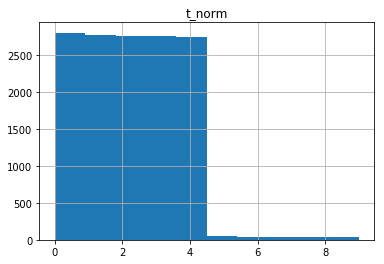

In [8]:
df_fold[['t_norm']].hist()

In [9]:
# filter patients with len(t_norm.unique()) != 5

df_temp = df_fold.apply(lambda x : (len(df_fold[df_fold['patient'] == x['patient']]['t_norm'].unique()) != 5), axis=1)

In [10]:
# how many patients do we have?
df_fold.shape
len(df_fold.patient.unique())

(14059, 9)

202

In [11]:
# how many patients with 5 labelled timesteps do we have?, difference have more or less timesteps
df = df_fold[~df_temp]
len(df.patient.unique())

193

In [12]:
df[df['t_norm'] == 0]['x_path'].shape
df[df['t_norm'] == 1]['x_path'].shape
df[df['t_norm'] == 2]['x_path'].shape
df[df['t_norm'] == 3]['x_path'].shape
df[df['t_norm'] == 4]['x_path'].shape

(2691,)

(2691,)

(2691,)

(2691,)

(2691,)

In [45]:
df.to_csv('reports/motion/2D/gcn/only_2d_slices_with_5_timesteps.csv')

In [13]:
df.head()

,Unnamed: 0,fold,x_path,y_path,modality,patient,t,z,t_norm
240,43789,0,data/raw/tetra/2D/train/0003-04NEJQUZ-2007-03-...,data/raw/tetra/2D/train/0003-04NEJQUZ-2007-03-...,train,0003-04NEJQUZ-2007-03-13,12,0,1
241,43790,0,data/raw/tetra/2D/train/0003-04NEJQUZ-2007-03-...,data/raw/tetra/2D/train/0003-04NEJQUZ-2007-03-...,train,0003-04NEJQUZ-2007-03-13,12,10,1
242,43791,0,data/raw/tetra/2D/train/0003-04NEJQUZ-2007-03-...,data/raw/tetra/2D/train/0003-04NEJQUZ-2007-03-...,train,0003-04NEJQUZ-2007-03-13,12,11,1
243,43792,0,data/raw/tetra/2D/train/0003-04NEJQUZ-2007-03-...,data/raw/tetra/2D/train/0003-04NEJQUZ-2007-03-...,train,0003-04NEJQUZ-2007-03-13,12,12,1
244,43793,0,data/raw/tetra/2D/train/0003-04NEJQUZ-2007-03-...,data/raw/tetra/2D/train/0003-04NEJQUZ-2007-03-...,train,0003-04NEJQUZ-2007-03-13,12,13,1


In [40]:
from src.data.generators import MotionDataGenerator
# create a list of z slices with t_n and t_n+1 , not possible for the last timestep
t_1 = np.concatenate([df[df['t_norm'] == 0]['x_path'].values, df[df['t_norm'] == 1]['x_path'].values, df[df['t_norm'] == 2]['x_path'].values, df[df['t_norm'] == 3]['x_path'].values])
t_2 = np.concatenate([df[df['t_norm'] == 1]['x_path'].values, df[df['t_norm'] == 2]['x_path'].values, df[df['t_norm'] == 3]['x_path'].values, df[df['t_norm'] == 4]['x_path'].values])
batch_generator = MotionDataGenerator(t_1, t_2)

2019-10-01 15:48:23,385 INFO Create DataGenerator
2019-10-01 15:48:23,417 INFO Datagenerator created with: 
 shape: [256, 256]
 batchsize: 32
 Scaler: MinMax
 Images: 10764 
 Augment_grid: False 
 Thread workers: 32
2019-10-01 15:48:23,417 INFO No augmentation


In [41]:
len(t_1)

10764

In [42]:
logging.getLogger().setLevel(logging.INFO)
from src.visualization.visualize import show_2D_or_3D

In [43]:
# Select batch generator output
x = ''
y = ''
@interact
def select_batch(batch = (0,len(batch_generator), 1)):
    global x, y
    x, y = batch_generator.__getitem__(batch)
    print(x.shape)
    print(y.shape)

interactive(children=(IntSlider(value=168, description='batch', max=336), Output()), _dom_classes=('widget-int…

In [44]:
@interact
def select_image_in_batch(im = (0,x.shape[0]- 1, 1)):
    
    # define a different logging level to make the generator steps visible
    logging.getLogger().setLevel(logging.INFO)
    show_2D_or_3D(x[im])
    plt.show()
    show_2D_or_3D(y[im])
    plt.show()

interactive(children=(IntSlider(value=15, description='im', max=31), Output()), _dom_classes=('widget-interact…

# tests with 4D networks

In [1]:
# -*- coding: UTF-8 -*-
from __future__ import division
import tensorflow as tf

# define logging and working directory
from ProjectRoot import change_wd_to_project_root
change_wd_to_project_root()
from src.utils.notebook_imports import *
from pyforest import *

GPU_IDS = '1'
current_gpu = choose_gpu_by_id(GPU_IDS)
print(current_gpu)

search for root_dir and set working directory
Working directory set to: /mnt/data/git/cardio
['gpu(0)']


Using TensorFlow backend.


In [ ]:
from src.models.vae import get_vae
encoder, decoder, vae = get_vae(config)